# Training model

This notebook allows you to create a model to classify cells.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from helpers import *

D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\ProjetSemestre\lib\site-packages\tensorflow\python\framework\dty

## Data loading

The loading is designed for csv file generated by the Collect Information option of the ImageJ plugin. If the class of the nuclei is not missing, the entire file will have the same class.

[TODO] write the path of your measurements files, create your dataset and write the possible classes

In [2]:
mouse_path = "../../data/H&E/measurements/mouse features.csv"
human_path = "../../data/H&E/measurements/human features.csv"
human_tumor_path = "../../data/H&E/measurements/human tumor features.csv"

mouse = get_data(mouse_path, "Mouse")
human = get_data(human_path, "Human")
human_tumor = get_data(human_tumor_path, "Human")

dataset = pd.concat([mouse, human, human_tumor], ignore_index=True)

classes = ["Mouse", "Human"]

headers = dataset.columns.values

for i, header in enumerate(headers):
    print(str(i) + " " + header)

0 Class
1 Nucleus minor Axis
2 Nucleus major Axis
3 Nucleus elongation
4 Cell minor Axis
5 Cell major Axis
6 Cell elongation
7 Nucleus area
8 Cell area
9 Area ratio
10 Direct neighbours mean distance
11 Direct neighbours variance distance
12 Lateral neighbours alignment
13 Lateral neighbours orientation differences
14 Lateral neighbours mean distance
15 Cells number in chain
16 Cells chain non reciprocal neighbours
17 Cells chain non reciprocal neighbours ratio
18 Cells chain tortuosity
19 Nucleus mean value channel 1
20 Nucleus variance value channel 1
21 Nucleus mean value channel 2
22 Nucleus variance value channel 2
23 Nucleus mean value channel 3
24 Nucleus variance value channel 3
25 Nucleus angular second moment
26 Nucleus contrast
27 Nucleus correlation
28 Nucleus sum of squares: variance
29 Nucleus inverse difference moment
30 Nucleus sum average
31 Nucleus sum variance
32 Nucleus sum entropy
33 Nucleus entropy
34 Nucleus difference variance
35 Nucleus difference entropy
36 Nu

In [3]:
dataset[CLASS_COLUMN].value_counts()

Human    47529
Mouse    41511
Name: Class, dtype: int64

## Data processing
Shuffle, normalize and split the data between inputs and targets.

In [4]:
#take the same number of values for each class, to take everything set -1
nb_values_per_class = dataset[CLASS_COLUMN].value_counts().min()

inputs, targets, mean_values, std_values = process_training_data(dataset, classes, nb_values_per_class)

CSBDeep need 3D images with more than 1 element in each dimension, we create an image of size (2, 2, feature_size / 4). If the feature size is not a multiple of 4, it will be padded with 0.

In [5]:
num_features = inputs.shape[1]
input_size = int(np.ceil(num_features/4) * 4)

inputs = resize_inputs(inputs)

## Model creation

Any model accepted by tensorflow can be used as long as it has the expected input and ouput.

In [6]:
optimizer = keras.optimizers.Adam()
loss_function = 'categorical_crossentropy'
              
demo_model = get_model(input_size, len(classes))
demo_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
demo_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 484)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               62080     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)      

## Cross validation 

In [7]:
from sklearn.model_selection import KFold

num_folds = 4
batch_size = 128
epochs = 100
validation_split = 0.2
verbose = 1

best_acc = 0

acc_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    model = get_model(input_size, len(classes))
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(inputs[train], targets[train], validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=verbose)

    metrics = evaluate(model, inputs[test], targets[test])
    acc = metrics[0]
    print(f'Score for fold {fold_no}: Accuracy of {acc*100}%')
    acc_per_fold.append(acc * 100)

    if(acc > best_acc):
        best_acc = acc
        best_metrics = metrics
        best_model = model
        best_model_history = history

    fold_no = fold_no + 1

    print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print('------------------------------------------------------------------------')

history = best_model_history
model = best_model

------------------------------------------------------------------------
Training for fold 1 ...
Train on 49812 samples, validate on 12454 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
49812/49812 [==============================] - 11s 214us/sample - loss: 0.5391 - acc: 0.7499 - val_loss: 0.2975 - val_acc: 0.8873
Epoch 2/100
49812/49812 [==============================] - 6s 125us/sample - loss: 0.3365 - acc: 0.8768 - val_loss: 0.2168 - val_acc: 0.9175
Epoch 3/100
49812/49812 [==============================] - 6s 118us/sample - loss: 0.2689 - acc: 0.9074 - val_loss: 0.1695 - val_acc: 0.9371
Epoch 4/100
49812/49812 [==============================] - 6s 116us/sample - loss: 0.2434 - acc: 0.9176 - val_loss: 0.1640 - val_acc: 0.9350
Epoch 5/100
49812/49812 [==============================] - 5s 105us/sample - loss: 0.2244 - acc: 0.9232 - val_loss: 0.1453 - val_acc: 0.9456
Epoch 6/100
49812/49812 [==============================] - 5s 106us/sample - loss: 0.2105 - acc: 0.

49812/49812 [==============================] - 3s 66us/sample - loss: 0.1633 - acc: 0.9411 - val_loss: 0.1251 - val_acc: 0.9522
Epoch 13/100
49812/49812 [==============================] - 3s 65us/sample - loss: 0.1646 - acc: 0.9397 - val_loss: 0.1181 - val_acc: 0.9549
Epoch 14/100
49812/49812 [==============================] - 3s 64us/sample - loss: 0.1574 - acc: 0.9418 - val_loss: 0.1239 - val_acc: 0.9503
Epoch 15/100
49812/49812 [==============================] - 3s 65us/sample - loss: 0.1581 - acc: 0.9429 - val_loss: 0.1162 - val_acc: 0.9542
Epoch 16/100
49812/49812 [==============================] - 3s 64us/sample - loss: 0.1580 - acc: 0.9432 - val_loss: 0.1286 - val_acc: 0.9508
Epoch 17/100
49812/49812 [==============================] - 3s 65us/sample - loss: 0.1562 - acc: 0.9441 - val_loss: 0.1207 - val_acc: 0.9533
Epoch 18/100
49812/49812 [==============================] - 3s 65us/sample - loss: 0.1554 - acc: 0.9427 - val_loss: 0.1137 - val_acc: 0.9549
Epoch 19/100
49812/49812 [

49813/49813 [==============================] - 3s 62us/sample - loss: 0.1406 - acc: 0.9497 - val_loss: 0.1062 - val_acc: 0.9586
Epoch 27/100
49813/49813 [==============================] - 3s 63us/sample - loss: 0.1383 - acc: 0.9505 - val_loss: 0.1056 - val_acc: 0.9593
Epoch 28/100
49813/49813 [==============================] - 3s 62us/sample - loss: 0.1355 - acc: 0.9514 - val_loss: 0.1052 - val_acc: 0.9591
Epoch 29/100
49813/49813 [==============================] - 3s 61us/sample - loss: 0.1348 - acc: 0.9518 - val_loss: 0.1066 - val_acc: 0.9583
Epoch 30/100
49813/49813 [==============================] - 3s 61us/sample - loss: 0.1318 - acc: 0.9516 - val_loss: 0.1106 - val_acc: 0.9549
Epoch 31/100
49813/49813 [==============================] - 3s 68us/sample - loss: 0.1315 - acc: 0.9523 - val_loss: 0.1085 - val_acc: 0.9601
Epoch 32/100
49813/49813 [==============================] - 3s 61us/sample - loss: 0.1317 - acc: 0.9524 - val_loss: 0.1063 - val_acc: 0.9599
Epoch 33/100
49813/49813 [

49813/49813 [==============================] - 5s 95us/sample - loss: 0.1255 - acc: 0.9546 - val_loss: 0.1117 - val_acc: 0.9571
Epoch 41/100
49813/49813 [==============================] - 6s 129us/sample - loss: 0.1276 - acc: 0.9547 - val_loss: 0.1115 - val_acc: 0.9570
Epoch 42/100
49813/49813 [==============================] - 5s 101us/sample - loss: 0.1203 - acc: 0.9574 - val_loss: 0.1153 - val_acc: 0.9558
Epoch 43/100
49813/49813 [==============================] - 4s 82us/sample - loss: 0.1235 - acc: 0.9566 - val_loss: 0.1153 - val_acc: 0.9582
Epoch 44/100
49813/49813 [==============================] - 4s 82us/sample - loss: 0.1264 - acc: 0.9557 - val_loss: 0.1078 - val_acc: 0.9585
Epoch 45/100
49813/49813 [==============================] - 4s 83us/sample - loss: 0.1265 - acc: 0.9557 - val_loss: 0.1119 - val_acc: 0.9567
Epoch 46/100
49813/49813 [==============================] - 3s 69us/sample - loss: 0.1225 - acc: 0.9563 - val_loss: 0.1119 - val_acc: 0.9572
Epoch 47/100
49813/49813

In [8]:
print('Best accuracy: %f' % best_acc)

for i, class_name in enumerate(classes):
    print('------------------------------------------------------------------------')
    print('Class: ' + class_name)
    print('Precision: %f' % best_metrics[1][i])
    print('Recall: %f' % best_metrics[2][i])
    print('F1 score: %f' % best_metrics[3][i])
    print('ROC AUC: %f' % best_metrics[4][i])
print('------------------------------------------------------------------------')

Best accuracy: 0.963962
------------------------------------------------------------------------
Class: Mouse
Precision: 0.960232
Recall: 0.967328
F1 score: 0.963767
ROC AUC: 0.994224
------------------------------------------------------------------------
Class: Human
Precision: 0.967680
Recall: 0.960657
F1 score: 0.964156
ROC AUC: 0.994224
------------------------------------------------------------------------


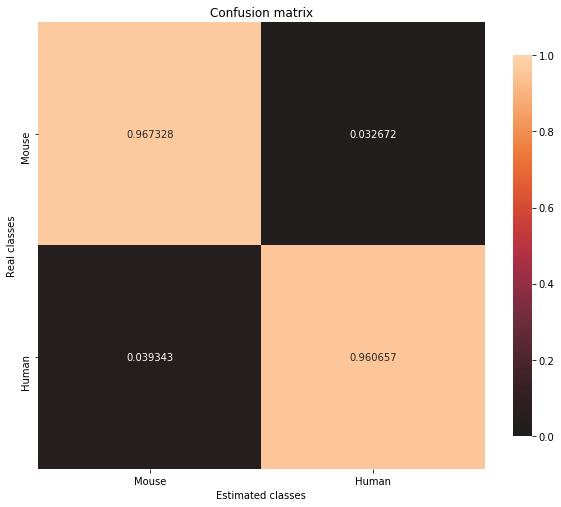

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.heatmap(best_metrics[5], ax=ax, vmin=0, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.7}, xticklabels=classes, yticklabels=classes, annot=True, fmt="f")
ax.set_title("Confusion matrix")
ax.set_xlabel('Estimated classes')
ax.set_ylabel('Real classes')
plt.show()

## Save the model

[TODO] write the path of the folder where you want your model to be saved

In [10]:
save_history(history, 'models/history.json')
save_model(model, mean_values, std_values, 'models/classification')

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/classification\saved_model.pb
